<a href="https://colab.research.google.com/github/Afuhnwi-Afriitech/dog-breed-classification/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dog breed identification from: https://www.kaggle.com/competitions/dog-breed-identification/data


In [1]:
!pip install kaggle

from google.colab import files
import os
import json

uploaded = files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
os.rename(list(uploaded.keys())[0], '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c dog-breed-identification

!unzip dog-breed-identification.zip

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

2.19.0
0.16.1


In [4]:
import pandas as pd
labels_csv = pd.read_csv('labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

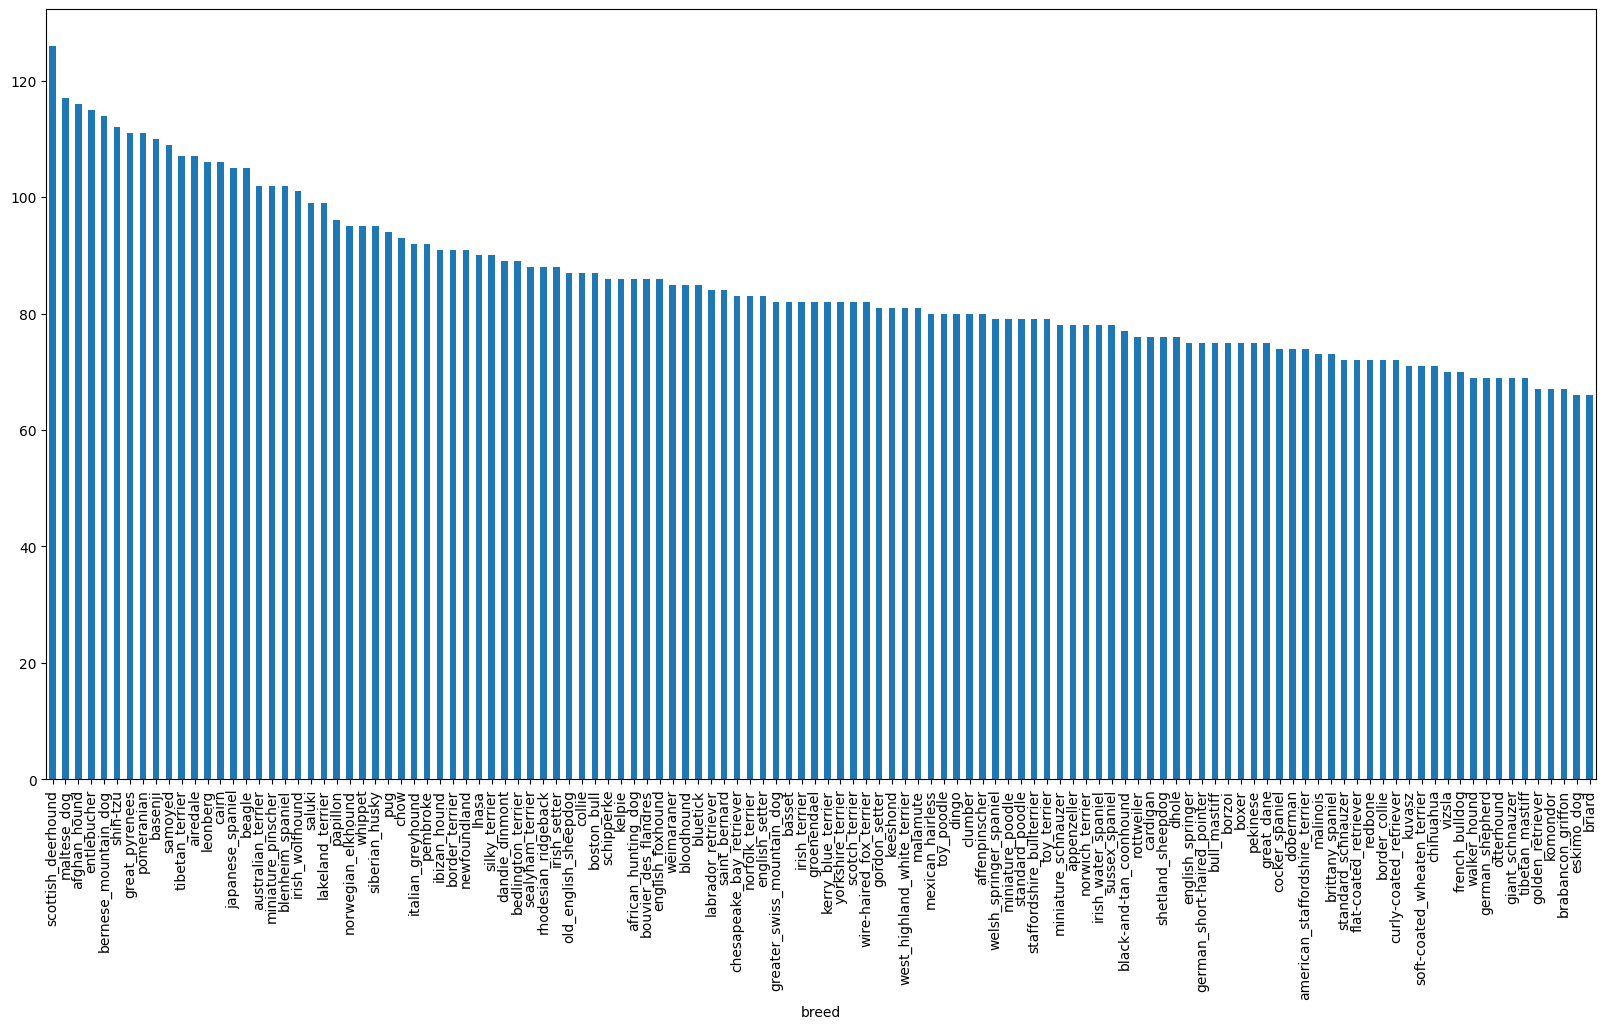

In [5]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

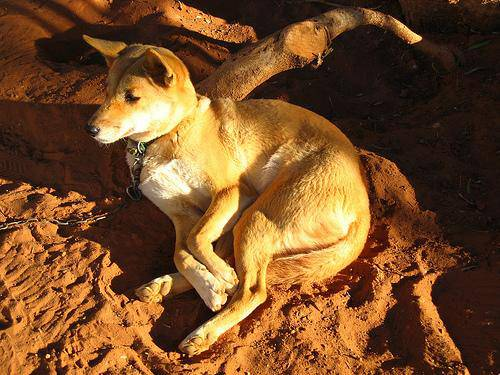

In [6]:
from IPython.display import Image
Image(filename=f'train/{labels_csv["id"][1]}.jpg')

In [7]:
filenames = ["/content/train/" + filename for filename in os.listdir('train')]
filenames[:10]

['/content/train/8c547b5df1aff986fa67f9efc97459b9.jpg',
 '/content/train/f194e48d99e5e0f279eb8cd5e6872e36.jpg',
 '/content/train/cb64a5454e405b6eef6061fda3433fe5.jpg',
 '/content/train/34117f0c3c594ec76e078a2bf208c10c.jpg',
 '/content/train/2197f4bff731d1de02ee0dfef5f4c860.jpg',
 '/content/train/51c09b0295e0137021db430c38308e8b.jpg',
 '/content/train/fd9aa3277a9635ecf6abbe637a78e521.jpg',
 '/content/train/0a438069d5a8a8a079ac131d74c3a366.jpg',
 '/content/train/7cd10b897b755a301850e2328a2dba4b.jpg',
 '/content/train/e818d5a7782350e72171c3dfa05af02a.jpg']

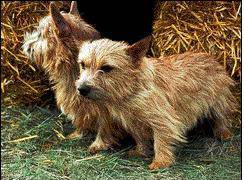

In [8]:
Image(filenames[9000])

In [9]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [10]:
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [11]:
if len(labels) == len(filenames):
  print("true")

true


In [12]:
import numpy as np
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [13]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [14]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [15]:
x = filenames
y = boolean_labels

In [16]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [62]:
#image processing
image_size = (224, 224)
def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=image_size)
  return image

In [63]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [64]:
BATCH_SIZE = 32
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("creating test batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("creating validation batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("creating training batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch


In [65]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_test, y_test, valid_data=True)

creating training batches
creating validation batches


In [66]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [67]:
import matplotlib.pyplot as plt
def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [68]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.10826331, 0.10042018, 0.12002802],
          [0.0936409 , 0.08971933, 0.10932717],
          [0.08766632, 0.09130777, 0.10713411],
          ...,
          [0.10741416, 0.12831844, 0.11230743],
          [0.11819847, 0.14030981, 0.11552865],
          [0.11955689, 0.14166823, 0.1129655 ]],
 
         [[0.10450806, 0.10042018, 0.12002802],
          [0.09720233, 0.09328075, 0.1128886 ],
          [0.09395728, 0.09759874, 0.11342507],
          ...,
          [0.15139173, 0.20121385, 0.17397584],
          [0.15909144, 0.20907395, 0.17411245],
          [0.13471287, 0.18469538, 0.14581232]],
 
         [[0.10292274, 0.10367554, 0.1209462 ],
          [0.09947511, 0.10079376, 0.1177815 ],
          [0.09653831, 0.11180442, 0.12370918],
          ...,
          [0.21338813, 0.28706634, 0.25307658],
          [0.20841548, 0.2820937 , 0.24054082],
          [0.15221263, 0.22747524, 0.1804164 ]],
 
         ...,
 
         [[0.4250338 , 0.5012927 , 0.32511795],
          [0.40354

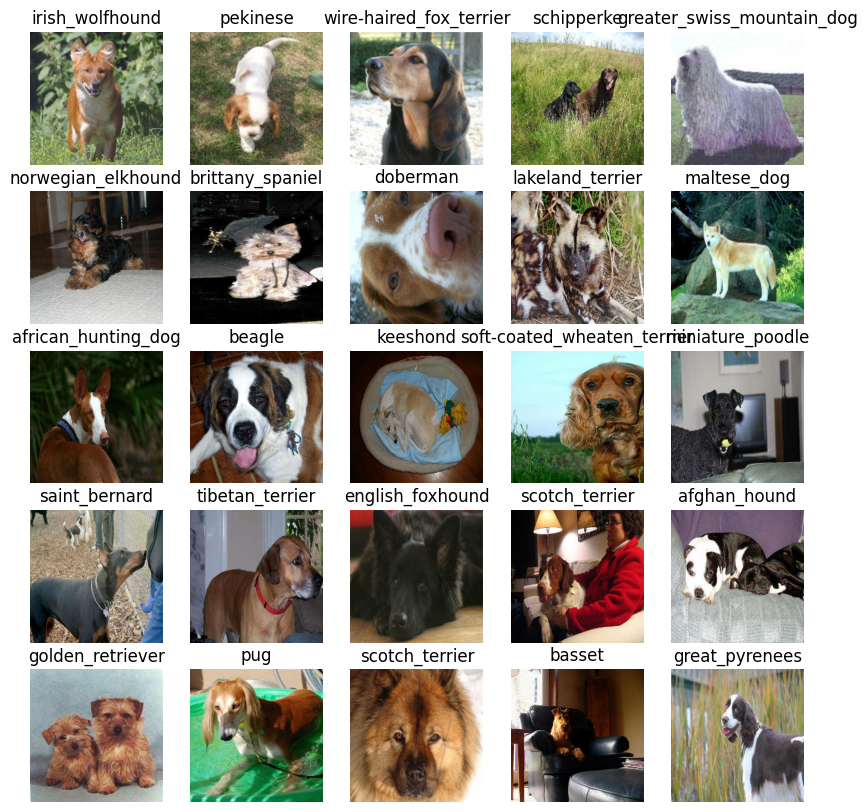

In [69]:
show_25_images(train_images, train_labels)

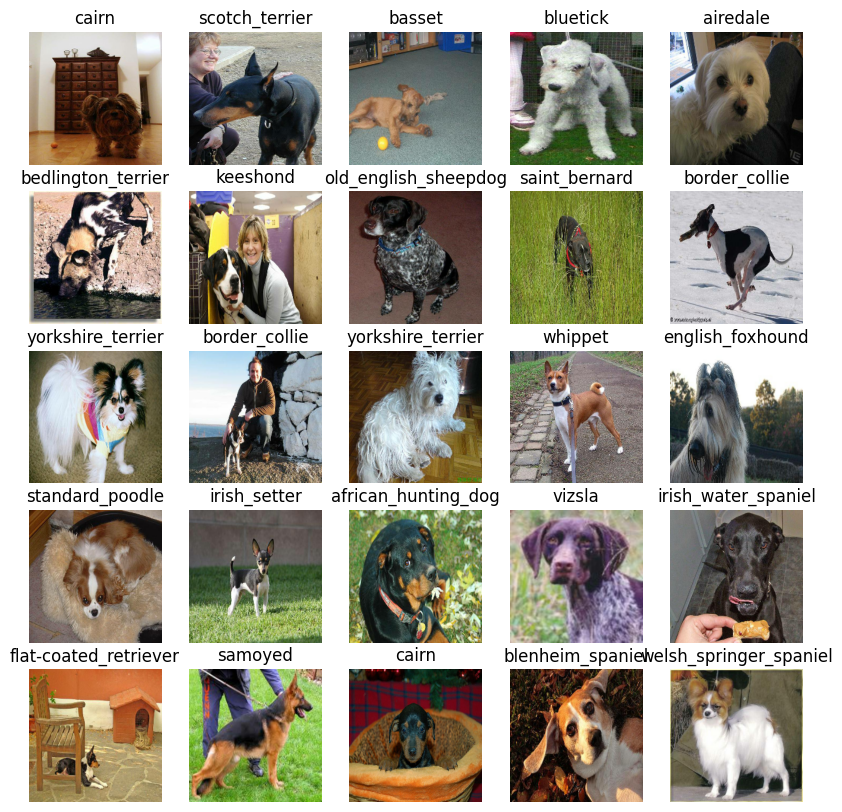

In [70]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

In [71]:
IMAGE_SHAPE = [224, 224, 3]
OUTPUT_SHAPE = len(unique_breeds)
Model_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
# Model_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
!pip install tf-keras
import tf_keras as keras
# from tensorflow import keras


In [72]:
def create_model(model_url=Model_URL, image_shape=IMAGE_SHAPE, output_shape=OUTPUT_SHAPE):
    print("building model with url:", model_url)
    model = keras.Sequential([
        hub.KerasLayer(model_url, input_shape=image_shape),
        keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [73]:
model = create_model()
model.summary()

building model with url: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_7 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [45]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
import datetime
def create_tensorboard_callback():
  log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
  return tensorboard_callback

In [75]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [76]:
NUM_EPOCH = 100 #@param {type: "slider", min: 10, max: 100}

In [77]:
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "not available (NO)")

GPU not available (NO)


In [78]:
def train_model():
  model = create_model()
  model.fit(x=train_data,
            epochs=NUM_EPOCH,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[create_tensorboard_callback(), early_stopping])
  return model

In [79]:
model = train_model()

building model with url: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 53s 2s/step - loss: 5.6123 - accuracy: 0.0113 - val_loss: 5.6048 - val_accuracy: 0.0050
Epoch 2/100
25/25 [==============================] - 47s 2s/step - loss: 3.7977 - accuracy: 0.1813 - val_loss: 5.7276 - val_accuracy: 0.0100
Epoch 3/100
25/25 [==============================] - 47s 2s/step - loss: 2.6829 - accuracy: 0.4487 - val_loss: 5.9124 - val_accuracy: 0.0050
Epoch 4/100
25/25 [==============================] - 46s 2s/step - loss: 1.8808 - accuracy: 0.7000 - val_loss: 6.1047 - val_accuracy: 0.0050
Epoch 5/100
25/25 [==============================] - 46s 2s/step - loss: 1.3248 - accuracy: 0.8425 - val_loss: 6.3007 - val_accuracy: 0.0050


In [ ]:
print("TensorFlow:", tf.__version__)
print("TensorBoard:", tb.__version__)